In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import expipe
import pathlib
import numpy as np
import spatial_maps.stats as stats
import septum_mec
import septum_mec.analysis.data_processing as dp
import septum_mec.analysis.registration
import head_direction.head as head
import spatial_maps as sp
import speed_cells.speed as spd
import re
import joblib
import multiprocessing
import shutil
import psutil
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from distutils.dir_util import copy_tree
from neo import SpikeTrain
import scipy
from functools import reduce
from tqdm.notebook import tqdm_notebook as tqdm
tqdm.pandas()

from spikewaveform.core import calculate_waveform_features_from_template, cluster_waveform_features

from septum_mec.analysis.plotting import violinplot, despine

from septum_mec.analysis.statistics import load_data_frames, make_paired_tables, make_statistics_table

## chose where to sample LFP

In [3]:
#################################################

# lfp_location = ''
lfp_location = '-other-tetrode'
# lfp_location = '-other-drive'

##################################################

In [4]:
%matplotlib inline
plt.rc('axes', titlesize=12)
plt.rcParams.update({
    'font.size': 12, 
    'figure.figsize': (6, 4), 
    'figure.dpi': 150
})

output_path = pathlib.Path("output") / ("stimulus-spike-lfp-response" + lfp_location)
(output_path / "statistics").mkdir(exist_ok=True, parents=True)
(output_path / "figures").mkdir(exist_ok=True, parents=True)
output_path.mkdir(exist_ok=True)

In [5]:
project_path = dp.project_path()
project = expipe.get_project(project_path)
actions = project.actions

In [6]:
data, labels, colors, queries = load_data_frames()

Number of sessions above threshold 194
Number of animals 4
Number of individual gridcells 139
Number of gridcell recordings 230


In [7]:
lfp_action = actions['stimulus-spike-lfp-response' + lfp_location]
lfp_results = pd.read_csv(lfp_action.data_path('results'))

In [8]:
# lfp_results has old unit id's but correct on (action, unit_name, channel_group)
lfp_results = lfp_results.drop('unit_id', axis=1)

In [9]:
data = data.merge(lfp_results, how='left')

In [10]:
data['stim_strength'] = data.stim_p_max / data.theta_peak

In [11]:
keys = [
    'theta_energy',
    'theta_peak',
    'theta_freq',
    'theta_half_width',
    'theta_vec_len',
    'theta_ang',
    'stim_energy',
    'stim_half_width',
    'stim_p_max',
    'stim_strength',
    'stim_vec_len',
    'stim_ang'
]

In [12]:
results, labels = make_paired_tables(data, keys)

In [13]:
results['gridcell']['theta_peak']

entity  unit_idnum  channel_group    date  Baseline I     11 Hz  \
51     1833           8              0   20719    0.251582       NaN   
85     1833          13              0   20719         NaN  0.057134   
86     1833          14              0   20719         NaN  0.049972   
58     1833          23              0  200619    0.247097       NaN   
127    1833          26              0  200619         NaN       NaN   
..      ...         ...            ...     ...         ...       ...   
139    1849         835              4  150319         NaN       NaN   
43     1849         851              5   60319    0.665441       NaN   
65     1849         932              7  280219    0.034074       NaN   
74     1849         937              7  280219         NaN  0.126604   
105    1849         939              7  280219         NaN       NaN   

     Baseline II     30 Hz  
51           NaN       NaN  
85      0.194778  0.042542  
86      0.129583       NaN  
58           NaN       NaN  
127     0.179928  0.034969  
..           ...       ...  
139          NaN  0.023559  
43           NaN       NaN  
65           NaN       NaN  
74           NaN       NaN  
105     0.246451       NaN  

[137 rows x 8 columns]

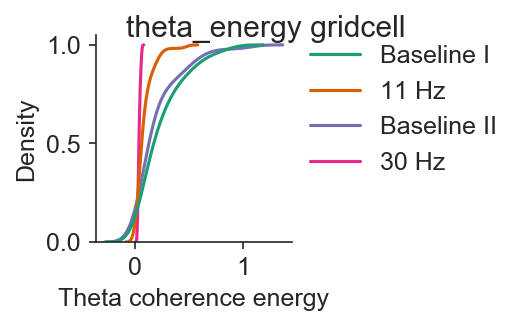

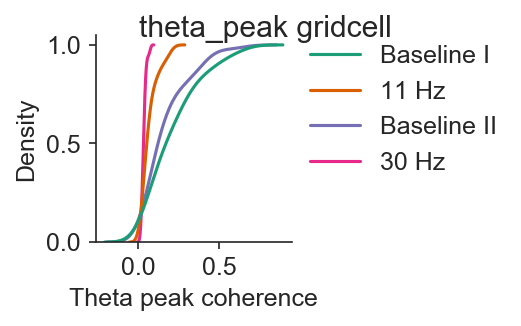

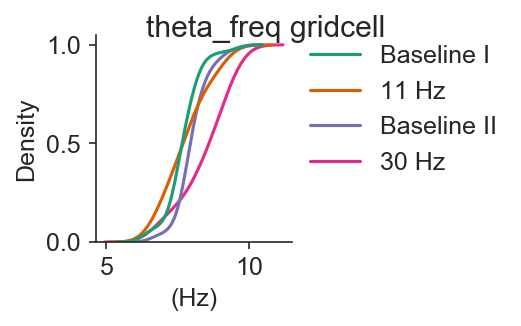

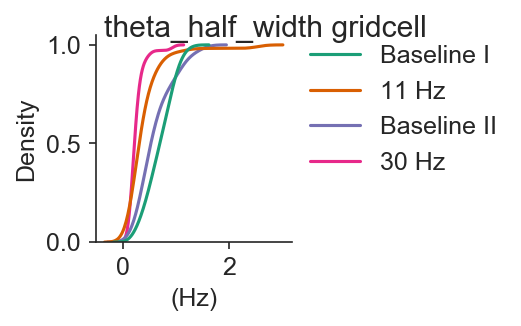

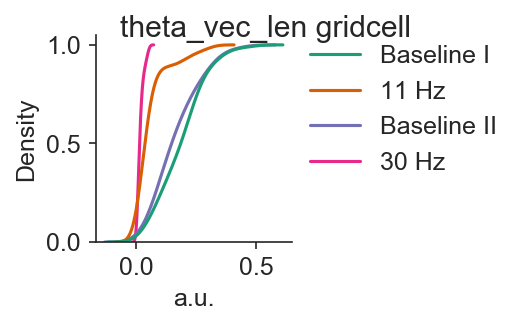

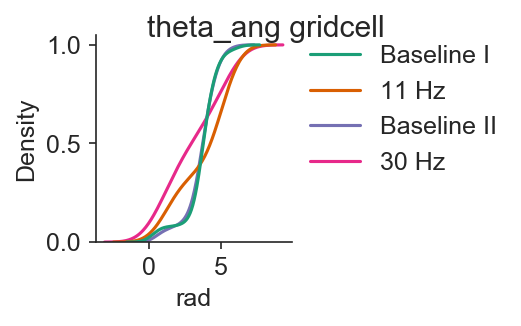

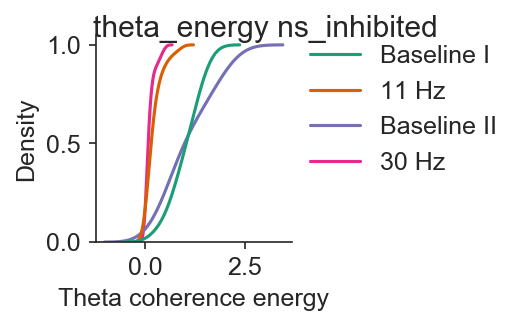

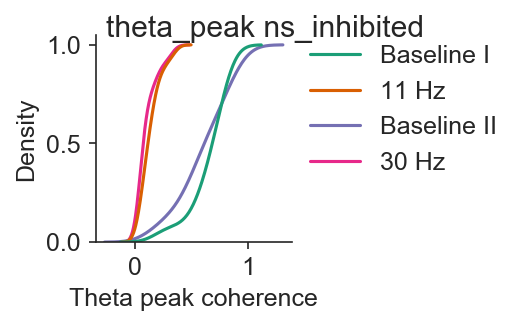

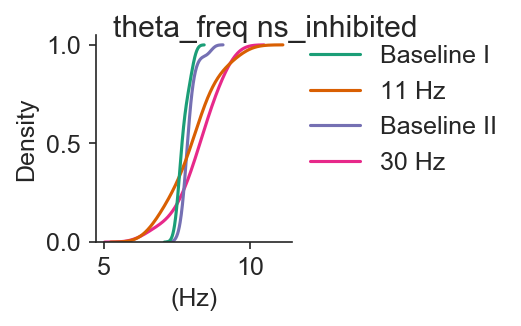

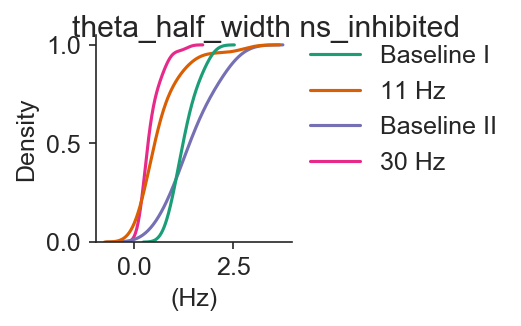

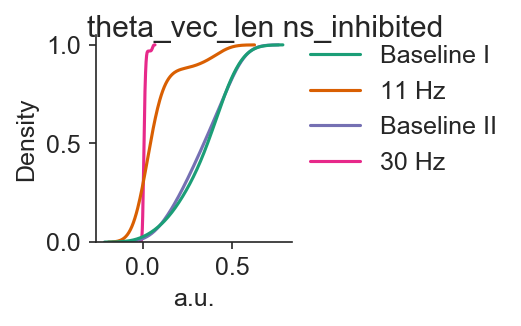

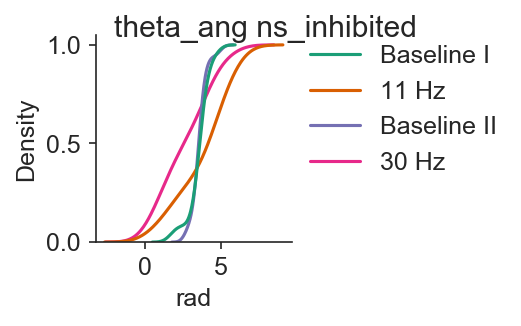

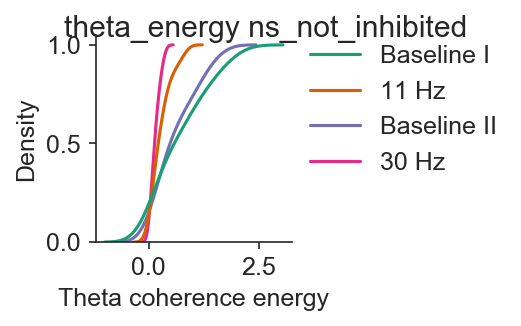

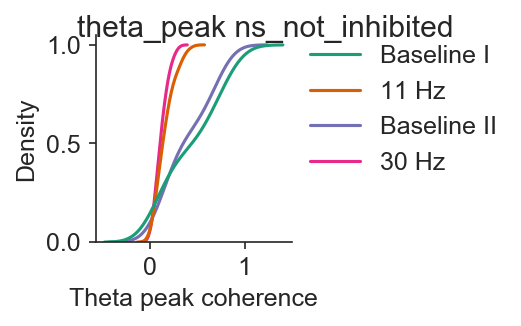

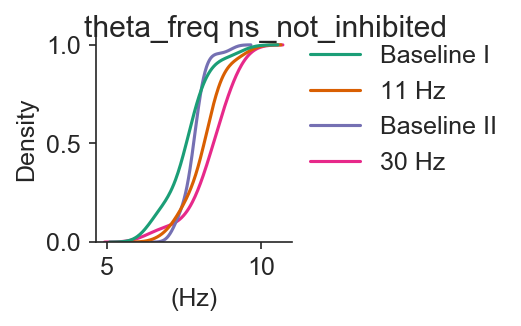

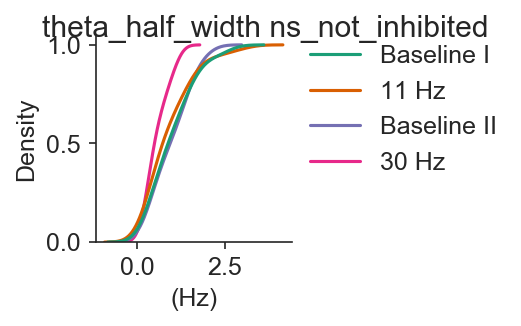

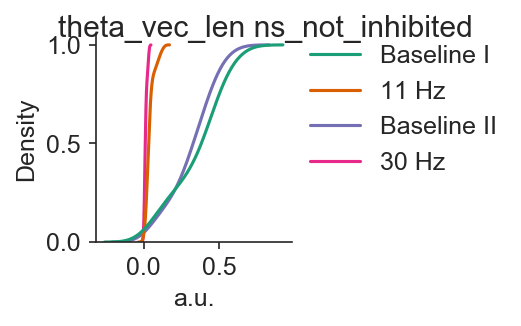

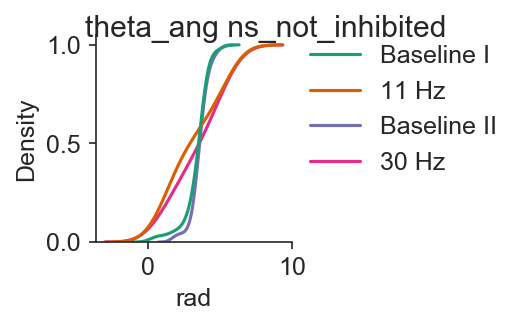

In [14]:
xlabel = {
    'theta_energy': 'Theta coherence energy',
    'theta_peak': 'Theta peak coherence',
    'theta_freq': '(Hz)',
    'theta_half_width': '(Hz)',
    'theta_vec_len': 'a.u.',
    'theta_ang': 'rad'
}
for cell_type in ['gridcell', 'ns_inhibited', 'ns_not_inhibited']:
    for key in xlabel:
        fig = plt.figure(figsize=(3.7,2.2))
        plt.suptitle(key + ' ' + cell_type)
        legend_lines = []
        for color, label in zip(colors, labels):
            legend_lines.append(matplotlib.lines.Line2D([0], [0], color=color, label=label))
        sns.kdeplot(data=results[cell_type][key].loc[:,labels], cumulative=True, legend=False, palette=colors, common_norm=False)
        plt.xlabel(xlabel[key])
        plt.legend(
            handles=legend_lines,
            bbox_to_anchor=(1.04,1), borderaxespad=0, frameon=False)
        plt.tight_layout()
        plt.grid(False)
        despine()
        figname = f'spike-lfp-coherence-histogram-{key}-{cell_type}'.replace(' ', '-')
        fig.savefig(
            output_path / 'figures' / f'{figname}.png', 
            bbox_inches='tight', transparent=True)
        fig.savefig(
            output_path / 'figures' / f'{figname}.svg', 
            bbox_inches='tight', transparent=True)

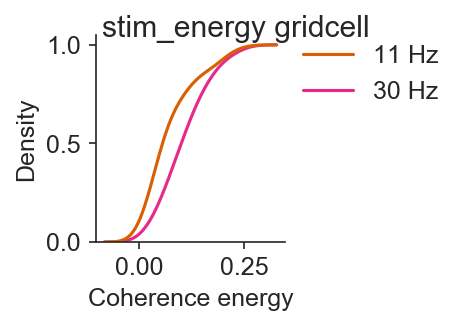

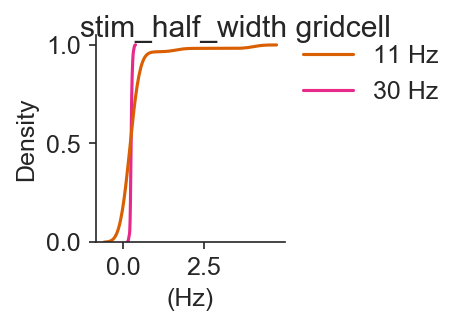

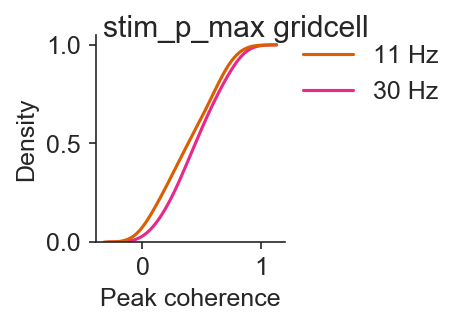

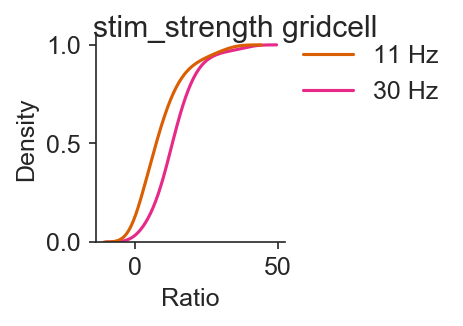

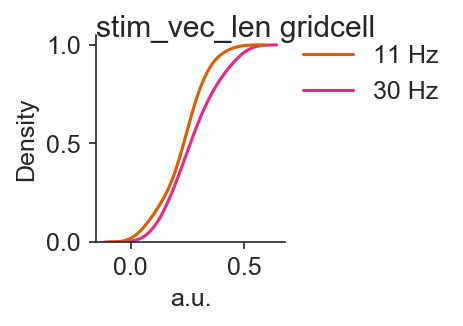

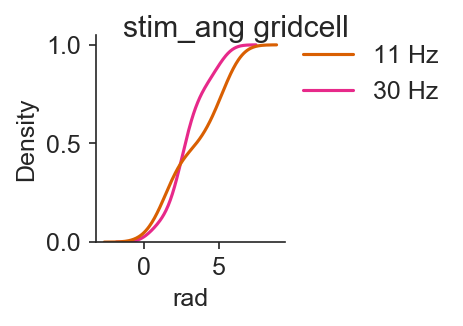

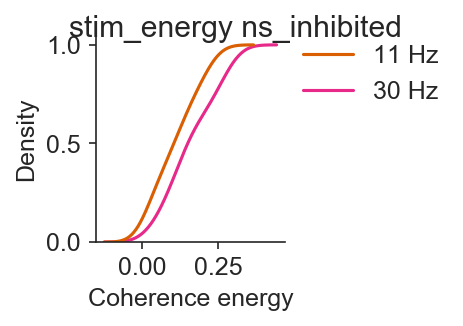

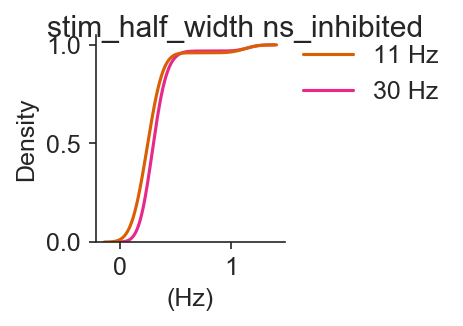

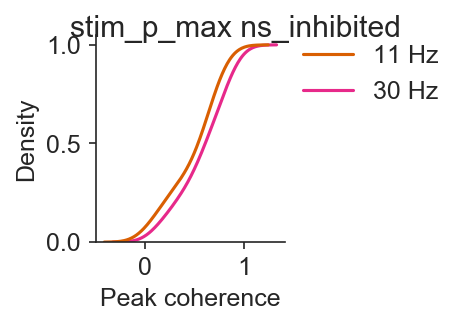

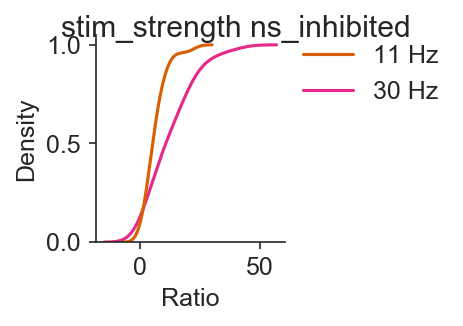

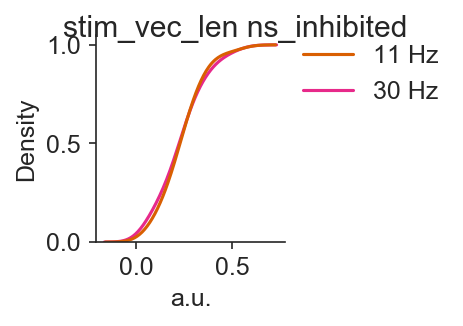

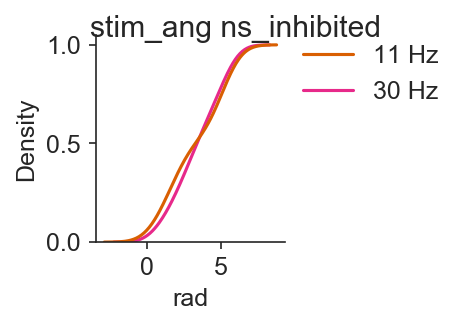

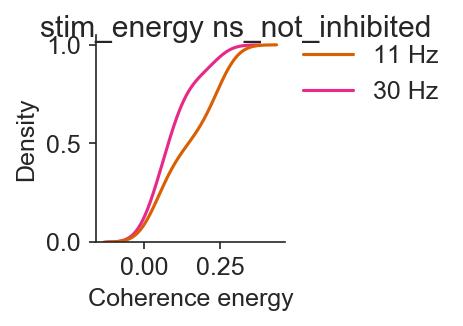

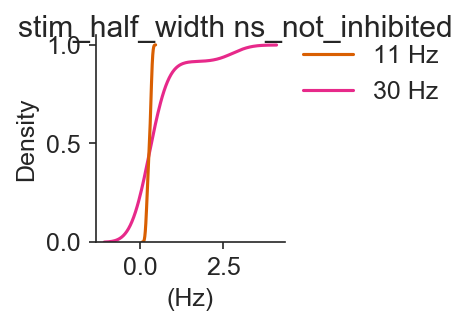

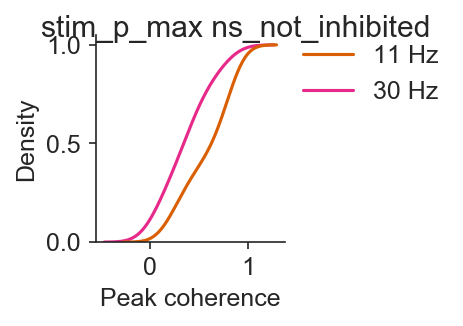

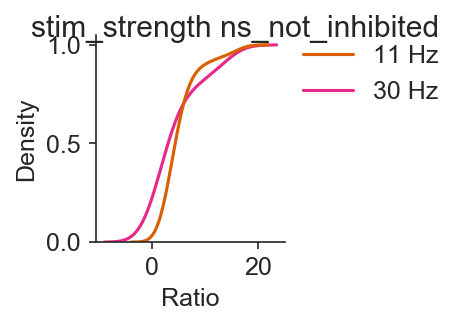

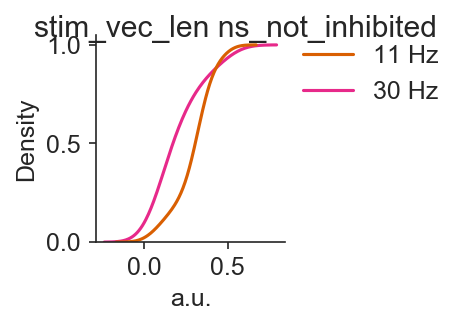

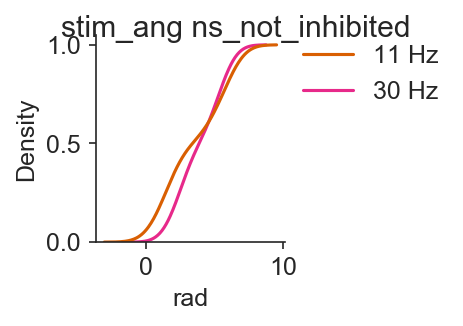

In [15]:
xlabel = {
    'stim_energy': 'Coherence energy',
    'stim_half_width': '(Hz)',
    'stim_p_max': 'Peak coherence',
    'stim_strength': 'Ratio',
    'stim_vec_len': 'a.u.',
    'stim_ang': 'rad'
}
# key = 'theta_energy'
# key = 'theta_peak'
for cell_type in ['gridcell', 'ns_inhibited', 'ns_not_inhibited']:
    for key in xlabel:
        fig = plt.figure(figsize=(3.3,2.2))
        plt.suptitle(key + ' ' + cell_type)
        legend_lines = []
        for color, label in zip(colors[1::2], labels[1::2]):
            legend_lines.append(matplotlib.lines.Line2D([0], [0], color=color, label=label))
        sns.kdeplot(data=results[cell_type][key].loc[:,labels[1::2]], cumulative=True, legend=False, palette=colors[1::2], common_norm=False)
        plt.xlabel(xlabel[key])
        plt.legend(
            handles=legend_lines,
            bbox_to_anchor=(1.04,1), borderaxespad=0, frameon=False)
        plt.tight_layout()
        plt.grid(False)
        despine()
        figname = f'spike-lfp-coherence-histogram-{key}-{cell_type}'.replace(' ', '-')
        fig.savefig(
            output_path / 'figures' / f'{figname}.png', 
            bbox_inches='tight', transparent=True)
        fig.savefig(
            output_path / 'figures' / f'{figname}.svg', 
            bbox_inches='tight', transparent=True)

## polar plot

In [16]:
from septum_mec.analysis.statistics import VonMisesKDE

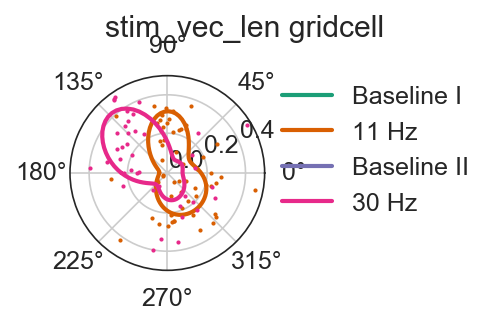

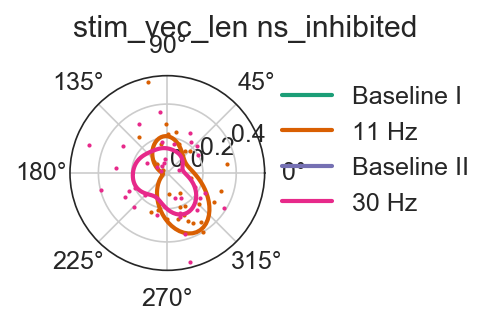

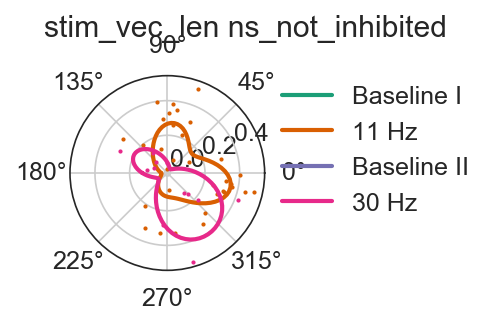

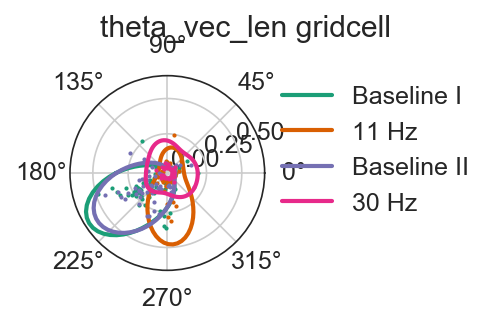

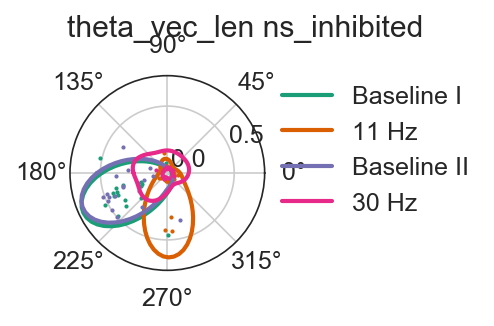

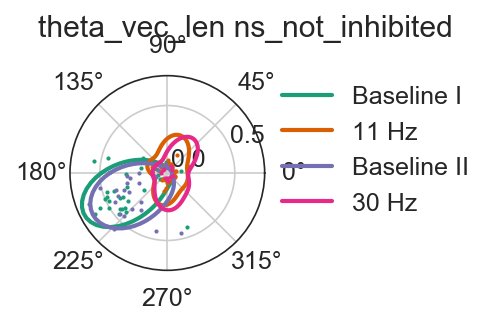

In [17]:
for paradigm in ['stim', 'theta']:
    key = paradigm + '_vec_len'
    for cell_type in ['gridcell', 'ns_inhibited', 'ns_not_inhibited']:
        fig = plt.figure(figsize=(3.2,2.2))
        plt.suptitle(key + ' ' + cell_type)
        legend_lines = []
        for color, query, label in zip(colors, queries, labels):
            data_query = data.query(query + ' and ' + cell_type)
            values = data_query[key].values
            angles = data_query[paradigm + '_ang'].values
            kde = VonMisesKDE(angles, weights=values, kappa=5)
            bins = np.linspace(-np.pi, np.pi, 100)
            plt.polar(bins, kde.evaluate(bins), color=color, lw=2)
            plt.polar(angles, values, color=color, lw=1, ls='none', marker='.', markersize=2)
#             values.hist(
#                 bins=bins[key], density=density, cumulative=cumulative, lw=lw, 
#                 histtype=histtype, color=color)
            legend_lines.append(matplotlib.lines.Line2D([0], [0], color=color, lw=2, label=label))
        plt.legend(
            handles=legend_lines,
            bbox_to_anchor=(1.04,1), borderaxespad=0, frameon=False)
        plt.tight_layout()
#         plt.grid(False)
        figname = f'spike-lfp-polar-plot-{paradigm}-{cell_type}'.replace(' ', '-')
        fig.savefig(
            output_path / 'figures' / f'{figname}.png', 
            bbox_inches='tight', transparent=True)
        fig.savefig(
            output_path / 'figures' / f'{figname}.svg', 
            bbox_inches='tight', transparent=True)

In [20]:
stats = {}
for cell_type, result in results.items():
    stats[cell_type], _ = make_statistics_table(result, labels)

In [21]:
stats['gridcell']

Theta energy              Theta peak  \
Baseline I                    2.5e-01 ± 3.3e-02 (63)  2.2e-01 ± 2.5e-02 (63)   
11 Hz                         1.1e-01 ± 1.6e-02 (56)  8.0e-02 ± 7.9e-03 (56)   
Baseline II                   2.7e-01 ± 3.2e-02 (46)  2.0e-01 ± 2.1e-02 (46)   
30 Hz                         3.7e-02 ± 1.5e-03 (35)  3.5e-02 ± 2.1e-03 (35)   
LMM Baseline I - 11 Hz                           NaN        1.5e-13, 1.4e-01   
LMM Baseline I - Baseline II       9.8e-01, -1.1e-03       3.7e-01, -2.8e-02   
LMM Baseline I - 30 Hz              1.1e-35, 1.9e-01        2.7e-09, 1.7e-01   
LMM 11 Hz - Baseline II             3.3e-02, 1.7e-01        1.1e-01, 1.2e-01   
LMM 11 Hz - 30 Hz                  1.4e-02, -6.8e-02                     NaN   
LMM Baseline II - 30 Hz             1.5e-02, 2.1e-01        3.6e-02, 1.5e-01   

                                          Theta freq        Theta half width  \
Baseline I                    7.6e+00 ± 9.6e-02 (63)  7.2e-01 ± 3.4e-02 (63)   
11 Hz                         7.7e+00 ± 1.2e-01 (56)  4.6e-01 ± 7.6e-02 (56)   
Baseline II                   8.2e+00 ± 7.7e-02 (46)  7.8e-01 ± 5.9e-02 (46)   
30 Hz                         8.8e+00 ± 1.6e-01 (35)  2.7e-01 ± 2.9e-02 (35)   
LMM Baseline I - 11 Hz             9.3e-01, -2.9e-02        1.5e-03, 2.8e-01   
LMM Baseline I - Baseline II        3.7e-02, 3.2e-01       9.7e-01, -5.1e-03   
LMM Baseline I - 30 Hz             1.4e-02, -9.9e-01        1.3e-09, 4.5e-01   
LMM 11 Hz - Baseline II             1.7e-01, 4.6e-01        7.4e-03, 3.3e-01   
LMM 11 Hz - 30 Hz                   1.5e-04, 8.8e-01       2.1e-03, -1.8e-01   
LMM Baseline II - 30 Hz            1.4e-01, -4.8e-01        1.1e-02, 4.7e-01   

                                       Theta vec len               Theta ang  \
Baseline I                    2.1e-01 ± 1.2e-02 (63)  3.9e+00 ± 1.3e-01 (63)   
11 Hz                         4.8e-02 ± 7.3e-03 (56)  3.5e+00 ± 2.7e-01 (56)   
Baseline II                   2.0e-01 ± 1.2e-02 (46)  3.6e+00 ± 1.3e-01 (46)   
30 Hz                         1.7e-02 ± 2.3e-03 (35)  3.3e+00 ± 3.8e-01 (35)   
LMM Baseline I - 11 Hz                           NaN        6.2e-01, 2.9e-01   
LMM Baseline I - Baseline II                     NaN       7.5e-01, -1.2e-01   
LMM Baseline I - 30 Hz              2.6e-12, 1.8e-01        1.3e-01, 7.9e-01   
LMM 11 Hz - Baseline II             1.6e-03, 1.3e-01       7.9e-01, -1.7e-01   
LMM 11 Hz - 30 Hz                  7.2e-02, -3.8e-02       7.6e-01, -2.3e-01   
LMM Baseline II - 30 Hz             1.2e-13, 1.7e-01        4.1e-01, 6.0e-01   

                                         Stim energy         Stim half width  \
Baseline I                                       NaN                     NaN   
11 Hz                         9.7e-02 ± 1.0e-02 (58)  3.0e-01 ± 5.1e-02 (58)   
Baseline II                                      NaN                     NaN   
30 Hz                         1.0e-01 ± 1.0e-02 (33)  2.6e-01 ± 5.1e-03 (33)   
LMM Baseline I - 11 Hz                           NaN                     NaN   
LMM Baseline I - Baseline II                     NaN                     NaN   
LMM Baseline I - 30 Hz                           NaN                     NaN   
LMM 11 Hz - Baseline II                          NaN                     NaN   
LMM 11 Hz - 30 Hz                   9.9e-01, 5.8e-04       5.9e-01, -5.3e-02   
LMM Baseline II - 30 Hz                          NaN                     NaN   

                                          Stim p max           Stim strength  \
Baseline I                                       NaN                     NaN   
11 Hz                         4.5e-01 ± 3.5e-02 (58)  8.2e+00 ± 9.1e-01 (58)   
Baseline II                                      NaN                     NaN   
30 Hz                         4.3e-01 ± 3.7e-02 (33)  1.3e+01 ± 1.1e+00 (33)   
LMM Baseline I - 11 Hz                           NaN                     NaN   
LMM Baseline I - Baseline II        

In [22]:
for cell_type, stat in stats.items():
    stat.to_latex(output_path / "statistics" / f"statistics_{cell_type}.tex")
    stat.to_csv(output_path / "statistics" / f"statistics_{cell_type}.csv")

In [23]:
for cell_type, cell_results in results.items():
    for key, result in cell_results.items():
        result.to_latex(output_path / "statistics" / f"values_{cell_type}_{key}.tex")
        result.to_csv(output_path / "statistics" / f"values_{cell_type}_{key}.csv")

# psd plots

In [24]:
from septum_mec.analysis.plotting import plot_bootstrap_timeseries

In [25]:
coher = pd.read_feather(output_path / 'data' / 'coherence.feather')
freqs = pd.read_feather(output_path / 'data' / 'freqs.feather')

In [26]:
freq = freqs.T.iloc[0].values

mask = (freq < 100)

In [ ]:
for cell_type in ['gridcell', 'ns_inhibited', 'ns_not_inhibited']:
    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(5,2))
    axs = axs.repeat(2)
    for i, (ax, query) in enumerate(zip(axs.ravel(), queries)):
        selection = [
            f'{r.action}_{r.channel_group}_{r.unit_name}' 
            for i, r in data.query(query + ' and ' + cell_type).iterrows()]
        values = coher.loc[mask, selection].dropna(axis=1).to_numpy()
        values = 10 * np.log10(values)
        plot_bootstrap_timeseries(freq[mask], values, ax=ax, lw=1, label=labels[i], color=colors[i])
    #     ax.set_title(titles[i])
        ax.set_xlabel('Frequency Hz')
        ax.legend(frameon=False)
        ax.set_ylim(-30, 0)
    axs[0].set_ylabel('Coherence')
    despine()
    figname = f'spike-lfp-coherence-{cell_type}'.replace(' ', '-')
    fig.savefig(
        output_path / 'figures' / f'{figname}.png', 
        bbox_inches='tight', transparent=True)
    fig.savefig(
        output_path / 'figures' / f'{figname}.svg', 
        bbox_inches='tight', transparent=True)

# NSni vs NSi analysis

In [ ]:
nsi_vs_nsni = {}
for key in keys:
    df = pd.DataFrame()
    dfs = [results[k][key].loc[:, ['entity', 'unit_idnum', 'Baseline I']].rename({'Baseline I': k}, axis=1) for k in ['ns_inhibited', 'ns_not_inhibited']]
    df = pd.merge(*dfs, on=['entity', 'unit_idnum'], how='outer')
    nsi_vs_nsni[key] = df

In [ ]:
nsi_vs_nsni.keys()

In [ ]:
nsi_vs_nsni['theta_energy']

In [ ]:
from septum_mec.analysis.statistics import LMM

In [ ]:
LMM(nsi_vs_nsni['theta_energy'], 'ns_inhibited', 'ns_not_inhibited', 'theta_energy')

In [ ]:
stat, stat_vals = make_statistics_table(nsi_vs_nsni, ['ns_inhibited', 'ns_not_inhibited'], wilcoxon_test=False)

In [ ]:
stat

In [ ]:
stat.to_latex(output_path / "statistics" / f"statistics_nsi_vs_nsni.tex")
stat.to_csv(output_path / "statistics" / f"statistics_nsi_vs_nsni.csv")

# Store results in Expipe action

In [ ]:
action = project.require_action("stimulus-spike-lfp-response" + lfp_location)

In [ ]:
copy_tree(output_path, str(action.data_path()))

In [ ]:
septum_mec.analysis.registration.store_notebook(action, "20_stimulus-spike-lfp-response.ipynb")